<a href="https://colab.research.google.com/github/UmaNadig/Melonama-/blob/main/N_V_Uma_Reddy_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Melanoma:

**Multiclass classification model using a custom convolutional neural network in TensorFlow.

*Problem Statement : To Build To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#library imports
!pip install tensorflow
!pip install keras
from tensorflow.keras.utils import to_categorical
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


Loading the dataset from google dive

In [7]:
train_dir = "/content/drive/MyDrive/melonama/Train"
test_dir = "/content/drive/MyDrive/melonama/Test"

counting the images in the dataset

In [8]:

image_count_train = len(list(pathlib.Path(train_dir).glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(test_dir).glob('*/*.jpg')))
print(image_count_test)

2239
118


In [9]:
class_names = os.listdir(train_dir)
class_names

['basal cell carcinoma',
 'dermatofibroma',
 'actinic keratosis',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Data processing by setting the hyper parameters

In [10]:

batch_size = 32
img_height = 180
img_width = 180


Dataset visualization

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width), label_mode='categorical',
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


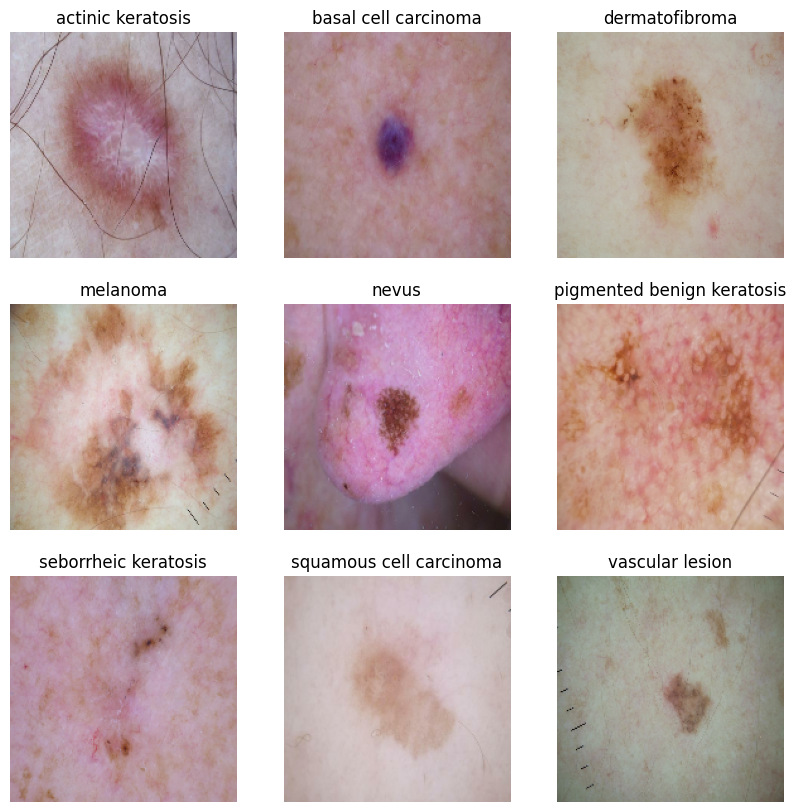

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [16]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,basal cell carcinoma,376
1,dermatofibroma,95
2,actinic keratosis,114
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [17]:
count= []
for path in pathlib.Path(test_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(test_dir)
                if os.path.isdir(os.path.join(test_dir, name))]

#return dataframe with image count and class.
df_test= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No. of Images in test dir'])
df_test

,Class_Name,No. of Images in test dir
0,actinic keratosis,16
1,basal cell carcinoma,16
2,dermatofibroma,16
3,melanoma,16
4,nevus,16
5,pigmented benign keratosis,16
6,seborrheic keratosis,3
7,squamous cell carcinoma,16
8,vascular lesion,3


<Axes: xlabel='No. of Images in test dir', ylabel='Class_Name'>

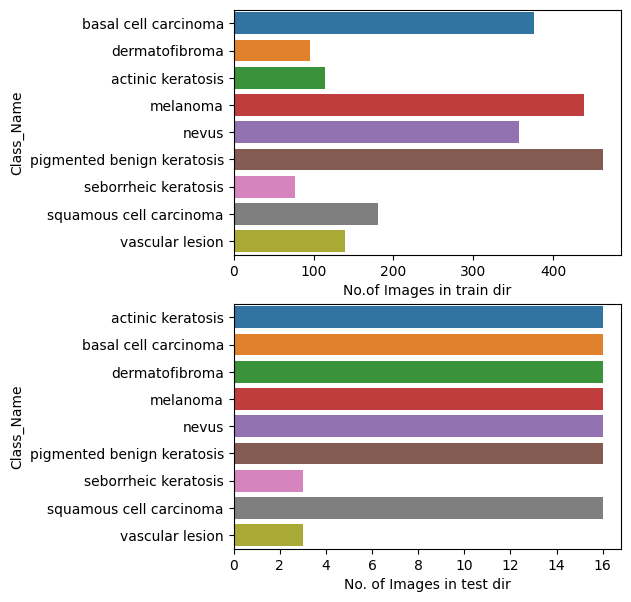

In [18]:

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
sns.barplot(x="No.of Images in train dir", y="Class_Name", data=df_train,
            label="Class_Name")
plt.subplot(2,1,2)
sns.barplot(x="No. of Images in test dir", y="Class_Name", data=df_test,
            label="Class")

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
input_shape = (180,180,3)
lr = 1e-3
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(11, 11), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (Batch  (None, 83, 83, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 64)        0

In [21]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [22]:
epochs = 20
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,callbacks=[earlystop])

Epoch 1/20
169/169 [==============================] - 1337s 2s/step - loss: 17.7791 - accuracy: 0.2787 - val_loss: 20.1056 - val_accuracy: 0.1232
Epoch 2/20
169/169 [==============================] - 10s 62ms/step - loss: 3.5567 - accuracy: 0.3433 - val_loss: 6.6973 - val_accuracy: 0.2249
Epoch 3/20
169/169 [==============================] - 10s 59ms/step - loss: 2.1746 - accuracy: 0.4041 - val_loss: 2.1211 - val_accuracy: 0.3497
Epoch 4/20
169/169 [==============================] - 10s 61ms/step - loss: 1.6995 - accuracy: 0.4577 - val_loss: 1.8446 - val_accuracy: 0.4298
Epoch 5/20
169/169 [==============================] - 10s 58ms/step - loss: 1.4547 - accuracy: 0.5122 - val_loss: 1.5065 - val_accuracy: 0.5115
Epoch 6/20
169/169 [==============================] - 10s 59ms/step - loss: 1.3032 - accuracy: 0.5580 - val_loss: 1.5702 - val_accuracy: 0.4863
Epoch 7/20
169/169 [==============================] - 10s 57ms/step - loss: 1.2444 - accuracy: 0.5695 - val_loss: 1.6279 - val_accurac

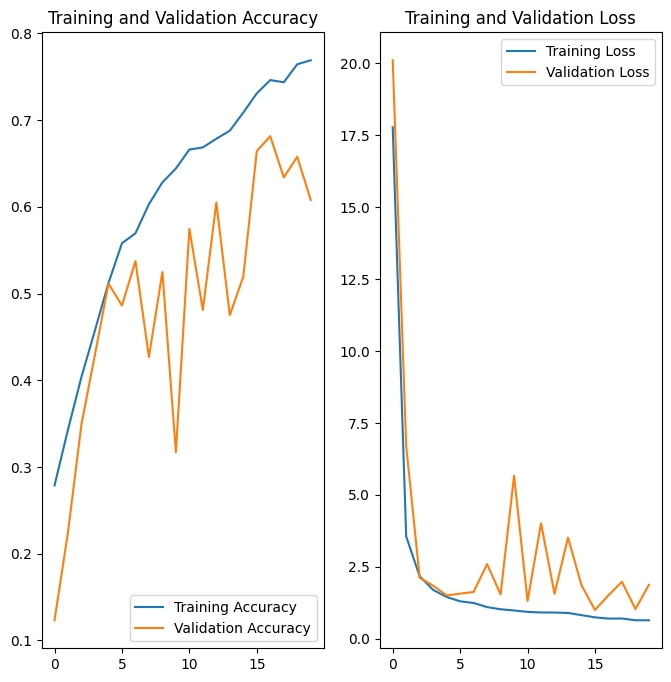

In [23]:




acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Define epochs_range based on the length of acc
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
#check the model over fitting or under fitting

In [25]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


43/43 [==============================] - 1s 16ms/step - loss: 1.8755 - accuracy: 0.6080
Accuracy:  0.6808234453201294
Validation Accuracy:  0.6080178022384644
Loss:  1.3709540367126465
Validation Loss 1.8754563331604004


model is over fitting, so data is augumented to improve the model performance

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
        'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
         'squamous cell carcinoma','vascular lesion']
train_batches = datagen.flow_from_directory(train_dir,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(test_dir,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 6739 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


Training the model after data augumentation

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        100416    
                                                                 
 batch_normalization (Batch  (None, 83, 83, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 64)        0

In [28]:
from keras.callbacks import EarlyStopping

epochs = 20
earlystop = EarlyStopping(monitor="val_accuracy", patience=10, mode="auto", verbose=1)
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs, callbacks=[earlystop])


Epoch 1/20
106/106 [==============================] - 167s 2s/step - loss: 1.3823 - accuracy: 0.5526 - val_loss: 5.0291 - val_accuracy: 0.3559
Epoch 2/20
106/106 [==============================] - 114s 1s/step - loss: 1.1980 - accuracy: 0.5670 - val_loss: 6.2686 - val_accuracy: 0.3475
Epoch 3/20
106/106 [==============================] - 108s 1s/step - loss: 1.1062 - accuracy: 0.5927 - val_loss: 4.7443 - val_accuracy: 0.4153
Epoch 4/20
106/106 [==============================] - 112s 1s/step - loss: 1.0381 - accuracy: 0.6235 - val_loss: 3.0006 - val_accuracy: 0.3051
Epoch 5/20
106/106 [==============================] - 109s 1s/step - loss: 1.0235 - accuracy: 0.6229 - val_loss: 4.1532 - val_accuracy: 0.2881
Epoch 6/20
106/106 [==============================] - 111s 1s/step - loss: 0.9659 - accuracy: 0.6504 - val_loss: 3.8889 - val_accuracy: 0.3305
Epoch 7/20
106/106 [==============================] - 111s 1s/step - loss: 0.9634 - accuracy: 0.6410 - val_loss: 3.4639 - val_accuracy: 0.3729

plotting results

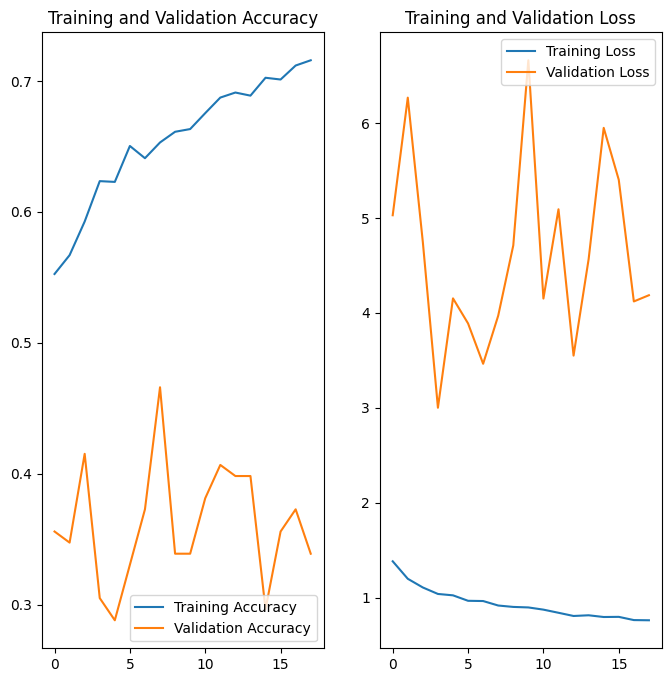

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 17
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()




In [30]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 17ms/step - loss: 0.5253 - accuracy: 0.7832
Accuracy:  0.813983678817749
Validation Accuracy:  0.783221960067749
Loss:  0.4854229688644409
Validation Loss 0.5253344178199768


In [31]:
count= []
for path in pathlib.Path(train_dir).iterdir():
    if path.is_dir():

      count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))

#name of the classes
sub_directory = [name for name in os.listdir(train_dir)
                if os.path.isdir(os.path.join(train_dir, name))]

#return dataframe with image count and class.
df_train= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class_Name', 'No.of Images in train dir'])
df_train

,Class_Name,No.of Images in train dir
0,basal cell carcinoma,376
1,dermatofibroma,95
2,actinic keratosis,114
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


model performance is not improved. So
the imbalanced dataset has to be balanced.
using augumentations, increasing each class count to 500

In [32]:
!pip install Augmentor

In [33]:
import Augmentor

In [34]:
path_to_training_dataset= train_dir+"/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0DDEFCB20>: 100%|██████████| 500/500 [00:23<00:00, 21.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78F0DDE63EE0>: 100%|██████████| 500/500 [00:23<00:00, 20.99 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0DCF80FD0>: 100%|██████████| 500/500 [00:24<00:00, 20.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1936x1296 at 0x78F0DDE63D90>: 100%|██████████| 500/500 [01:17<00:00,  6.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78F0DDE285E0>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F178FCB940>: 100%|██████████| 500/500 [00:18<00:00, 27.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78F0DDEFFE50>: 100%|██████████| 500/500 [00:40<00:00, 12.41 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F0DCF80FD0>: 100%|██████████| 500/500 [00:17<00:00, 28.91 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/melonama/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78F178FCB940>: 100%|██████████| 500/500 [00:19<00:00, 25.86 Samples/s]


In [35]:
image_count_train = len(list(pathlib.Path(train_dir).glob('*/output/*.jpg')))
print(image_count_train)

9000


In [36]:
path_list = [x for x in glob.glob(os.path.join(pathlib.Path(train_dir), '*','output', '*.jpg'))]

In [37]:
Balanced_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_dir, '*','output', '*.jpg'))]


In [38]:
dataframe_dict_new = dict(zip(path_list, Balanced_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

basal cell carcinoma          1000
dermatofibroma                1000
actinic keratosis             1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: Label, dtype: int64

In [41]:
data_dir_train="/content/drive/MyDrive/melonama/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),label_mode='categorical',
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [43]:
input_shape = (180,180,3)
lr = 1e-4
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense (9, activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 39, 39, 128)      

In [44]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("/content/drive/MyDrive/melonama/model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

In [45]:
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
280/281 [============================>.] - ETA: 0s - loss: 1.7098 - accuracy: 0.3410
Epoch 1: val_accuracy improved from -inf to 0.44281, saving model to /content/drive/MyDrive/melonama/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 82s 271ms/step - loss: 1.7085 - accuracy: 0.3412 - val_loss: 1.4463 - val_accuracy: 0.4428
Epoch 2/30
281/281 [==============================] - ETA: 0s - loss: 1.4040 - accuracy: 0.4684
Epoch 2: val_accuracy improved from 0.44281 to 0.53449, saving model to /content/drive/MyDrive/melonama/model.h5
281/281 [==============================] - 61s 214ms/step - loss: 1.4040 - accuracy: 0.4684 - val_loss: 1.2471 - val_accuracy: 0.5345
Epoch 3/30
281/281 [==============================] - ETA: 0s - loss: 1.1817 - accuracy: 0.5546
Epoch 3: val_accuracy improved from 0.53449 to 0.57944, saving model to /content/drive/MyDrive/melonama/model.h5
281/281 [==============================] - 55s 191ms/step - loss: 1.1817 - accuracy: 0.5546 - val_loss: 1.1586 - val_accuracy: 0.5794
Epoch 4/30
281/281 [==============================] - ETA: 0s - loss: 0.9637 - accuracy: 0.6488
Epoch 4: val_accuracy improved from 0.57944 to 0.67423, saving model to /content/dri

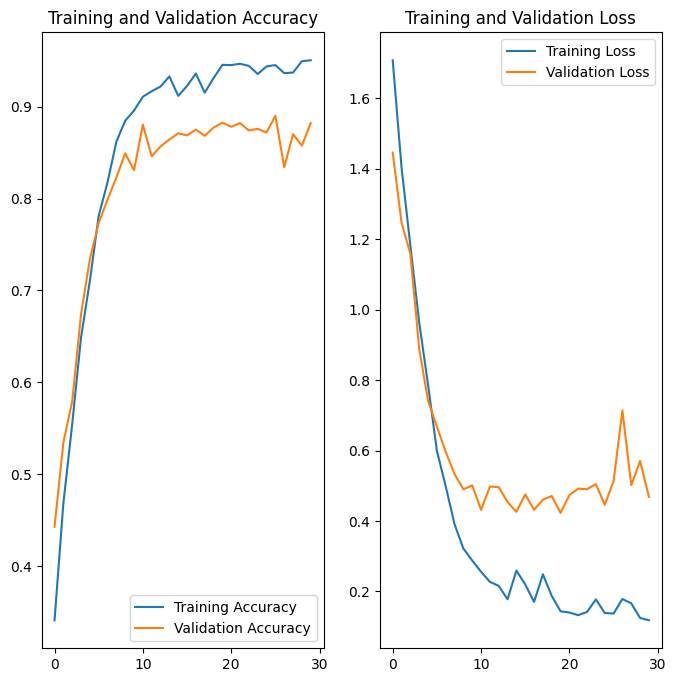

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 30
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After balancing the data, From training accuracy and validation accuracy we can conclude that the model is stable val accuracy is 88.21  further increasing the number of epochs will improve the accuracy

In [47]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

71/71 [==============================] - 9s 110ms/step - loss: 0.4684 - accuracy: 0.8821
Accuracy:  0.9588522911071777
Validation Accuracy:  0.8820649981498718
Loss:  0.0889657512307167
Validation Loss 0.46835750341415405


**Model Predictions on Test Image** on images

1/1 [==============================] - 0s 255ms/step
Actual Class dermatofibroma
Predictive Class actinic keratosis


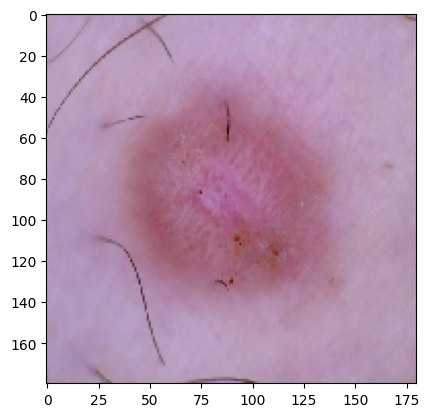

In [48]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
class_names=os.listdir('/content/drive/MyDrive/melonama/Test')
class_num=2
Test_image_path = os.path.join(pathlib.Path(test_dir), class_names[class_num], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)

pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[class_num] +'\n'+ "Predictive Class "+pred_class )